https://colab.research.google.com/notebooks/io.ipynb

Dataloader:
  - sentence embedding (100 forward pass / minutes, 10 minutes epoch train)
  - pas loader plusieurs fois la meme image
  - data augmentation (resize, randomresizecrop)

Model
  - crop dataloader (image augmentation)
  - dropout
  - Model ensembling
  - Lr scheduler
  - Early stop

Pas permis:
 - Scale l'image en 224x224 et utiliser un réseau préentrainé


Ne pas oublier 
net.train(), net.eval() ne calcule pas les gradients et le dropout

procedure d'entrainement, sauver le meilleur modele,
Adam optimizer


Rapport :
- Explorez le jeu de données, donnez des exemples pour quelques classes, la distribution des labels (sous forme de graph ?)
- Quand vous prenez une decision (par exemple, data augementation), montrez visuellement l'effet de cette décision
- Expliquez votre réseau, que sont des convolution et du pooling, mettez des figures, expliquez votre stratégie pour définir la taille des filtres, etc..
- Montrez l'évolution de vos résultats par epoch (sous forme de graph ?), plottez l'accuracy, et la loss. Quelle stratégie d'apprentissage utilisez vous (lr scheduler, early stop, ...)
- Si vous utilisez du dropout, model ensembling, autre technique : explication et effet de cette technique, ...
- PS: on a surement pas le temps de tout faire ! Concentrez vous sur certains points, et montrez leur impact (qu'il soit négatif ou positif, c'est ca la science...)

In [ ]:
!file=1pfd5-i_F20zViKIYwbQ8jL1p78s_E6uX && wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='${file} -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="${file} -O images.zip && rm -rf /tmp/cookies.txt \
&& unzip -qq images.zip && \
git clone https://github.com/jbdel/miniVQA

In [ ]:
!ls && ls -d miniVQA/*

In [ ]:
!file=1-2BoKlduGcbjkCjT0IOHjtfhSXbQjTDd && wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='${file} -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="${file} -O sentence_embeddings.zip && rm -rf /tmp/cookies.txt \
&& unzip sentence_embeddings.zip

## **Overview dataset**

In [ ]:
!wc -l miniVQA/*.csv

  6288 miniVQA/sample_submission.csv
  6288 miniVQA/test.csv
 50300 miniVQA/train.csv
  6300 miniVQA/val.csv
 69176 total


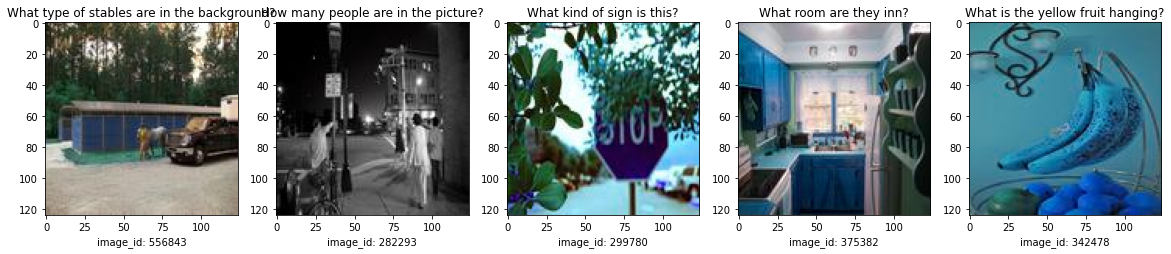

In [ ]:
import json
import random
import matplotlib.pyplot as plt
import cv2

image_question = json.load(open('miniVQA/image_question.json'))
plt.figure(figsize=([20, 20]))

for i in range(5):
  plt.subplot(1, 5, i+1)
  random_image = random.choice(list(image_question.keys()))
  _, random_question = random.choice(image_question[random_image])
  plt.imshow(cv2.resize(cv2.imread('image124/'+random_image+'.jpg'), (124,124)))
  plt.xlabel('image_id: '+random_image)
  plt.title(random_question)

## **Sentence Embedding**

In [ ]:
!pip install sentence_transformers

In [ ]:
from sentence_transformers import SentenceTransformer
import time

model = SentenceTransformer('distilbert-base-nli-mean-tokens').cuda()
sentences = 'This framework generates embeddings for each input sentence'
time_start = time.time()
sentence_embeddings = model.encode(sentences)
print(time.time()-time_start)
print(sentence_embeddings.shape)


100%|██████████| 245M/245M [00:16<00:00, 14.8MB/s]


0.1373608112335205
(768,)


# Dataloader efficace

In [ ]:
import torch
import json
import csv
from torch.utils.data import Dataset
from torchvision.transforms import *
from PIL import Image
import os
import numpy as np
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm
import pickle
from google.colab import files

test_transform = transforms.Compose([
            transforms.Resize((112,112)),
            transforms.ToTensor(),
        ])      

train_transform = transforms.Compose([
            transforms.RandomResizedCrop((112,112)),
            transforms.ToTensor(),
        ])      

question_embedder = SentenceTransformer('distilbert-base-nli-mean-tokens').cuda()

class MiniVQA(Dataset):
  def __init__(self, name):
    super(MiniVQA, self).__init__()
    assert name in ["train","val","test"]

    data_csv = csv.DictReader(open('miniVQA/'+name+'.csv'), delimiter=',')
    # Question_id -> label
    self.questionId_label = {int(row['id']): row['label'] for row in data_csv}
    # Set of question ids
    self.questionIds = list(self.questionId_label.keys())
    # Num of labels
    self.num_answer = len(set(self.questionId_label.values()))
    # index to label
    self.labels = open("miniVQA/answer_list.txt", "r").read().splitlines()
    # Image to questions
    self.image_question = json.load(open('miniVQA/image_question.json'))

    # Preprocessing
    # We need to have a dict questionId -> (question_embedding, image_id) 
    question_file = "miniVQA/"+name+"_question_embeddings.pkl"
    if os.path.exists(question_file):
      print("Loading ", question_file)
      self.questionId_qi = pickle.load(open(question_file,'rb'))
    else:
      print("Creating ", question_file)
      self.questionId_qi = {}
      for image_id, questions in tqdm(self.image_question.items(), total=len(self.image_question)):
        for q in questions:
          question_id, question = q
          if question_id in self.questionIds:            
            self.questionId_qi[question_id] = (question_embedder.encode(question), image_id)       

      pickle.dump(self.questionId_qi, open(question_file, 'wb'))

    if name == 'train':
      self.transform = train_transform
    else:
      self.transform = test_transform

    self.name = name

  def __len__(self):
    return len(self.questionIds)

  def __getitem__(self, idx):
    id = self.questionIds[idx]
    # Question and image_id
    question_embedding, image_id = self.questionId_qi[id]
    # Image from image_id
    img = self.transform(Image.open('image124/'+image_id+'.jpg').convert('RGB'))
    # Label
    if self.name == 'test':
      label = np.array(-1) # bidon
    else:
      label = np.array(self.questionId_label[id], dtype=np.long)

    return id, question_embedding, img, label

test_dataset = MiniVQA("test")
val_dataset = MiniVQA("val")
train_dataset = MiniVQA("train")

# Vérifier le bon nombre de samples 
print("Nombre de samples pour train", len(train_dataset))
print("Nombre de samples pour val", len(val_dataset))
print("Nombre de samples pour test", len(test_dataset))

training_generator = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_generator = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# for i in tqdm(range(len(train_dataset))):
#   train_dataset.__getitem__(i)

Loading  miniVQA/test_question_embeddings.pkl
Loading  miniVQA/val_question_embeddings.pkl
Loading  miniVQA/train_question_embeddings.pkl
Nombre de samples pour train 50300
Nombre de samples pour val 6300
Nombre de samples pour test 6288


In [ ]:
# !zip question_embeddings.zip miniVQA/*.pkl

## **Training**

In [ ]:
import torch.optim as optim
import time

def train(net, batch_size=64, learning_rate=1e-3, num_epochs=99999999999, max_early_stop=5):
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=0, factor=0.8)
    early_stop = 0
    best_accuracy = 0.0

    for epoch in range(num_epochs):
      net.train() # nouveau
      epoch_start = time.time()
      for iteration, sample in enumerate(training_generator):
        _, question, img, label = sample
        optimizer.zero_grad()
        out = net(img.cuda(), question.cuda())
        loss = loss_func(out, label.cuda())
        loss.backward()
        optimizer.step()
        
        print("\r[Epoch %2d][Step %4d/%4d] Loss: %.4f, Lr: %.2e, ES: %2d" % (
                        epoch + 1,
                        iteration,
                        int(len(training_generator.dataset) / batch_size),
                        loss.cpu().data.numpy() / batch_size,
                        *[group['lr'] for group in optimizer.param_groups],
                        early_stop,
                    ), end='          ')
        
      epoch_end = time.time() - epoch_start
      net.eval()
      accuracy = []
      val_loss = 0
      for j, sample in enumerate(val_generator):
        _, question, img, label = sample
        out = net(img.cuda(), question.cuda())
        val_loss += loss_func(out, label.cuda()).data.cpu()
        best = np.argmax(out.data.cpu().numpy(), axis=-1)
        accuracy.extend(list(best == label.data.cpu().numpy()))
      
      early_stop += 1
      val_accuracy = np.mean(accuracy)*100
      # Best model found
      if val_accuracy > best_accuracy:
        torch.save(net.state_dict(), 'best_model.pth') 
        best_accuracy = val_accuracy
        early_stop = 0

      print('\n epoch_time', str(epoch_end),
            'val_acc', str(val_accuracy), 
            'val_loss', str(val_loss.item()),
            'best_acc', str(best_accuracy))
      scheduler.step(val_accuracy)

      # No improvements for max_early_stop epochs
      if early_stop == max_early_stop:
        break

    print("Training done, testing")
    soumission = []
    net.load_state_dict(torch.load('best_model.pth'))
    net.eval()
    for j, sample in enumerate(test_generator):
      id, question, img, label = sample
      out = net(img.cuda(), question.cuda())
      best = np.argmax(out.data.cpu().numpy(), axis=-1)
      soumission.append(str(id.item())+','+str(best.item()))
    open('soumission.csv', 'w+').write('id,label\n'+'\n'.join(map(str, soumission)))
    files.download('soumission.csv')

In [ ]:
from torchvision.models import ResNet
from torchvision.models.resnet import BasicBlock, Bottleneck
from torchvision.models.utils import load_state_dict_from_url

import torch.nn as nn

class Network(ResNet):
  def __init__(self, block, layers, flatten_size, question_size, pretrained=None):
    super(Network, self).__init__(block, layers)
    if pretrained is not None:
        state_dict = load_state_dict_from_url(pretrained,
                                              progress=True)
        self.load_state_dict(state_dict)

    self.fc = nn.Linear(flatten_size + question_size, train_dataset.num_answer)
    self.dropout = nn.Dropout(p=0.5)

  def forward(self, x, question):

      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.maxpool(x)

      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)
      # print(x.shape)
      # x = self.avgpool(x)
      x = torch.flatten(x, 1)
      x = torch.cat((x,question), 1)
      x = self.dropout(x)
      x = self.fc(x)

      return x

# 57 secondes / epoch 
net = Network(BasicBlock, [2, 2, 2, 2], flatten_size=512*4*4, question_size=768, 
              pretrained="https://download.pytorch.org/models/resnet18-5c106cde.pth")
# 118 secondes / epoch 
# net = Network(Bottleneck, [3, 4, 6, 3], flatten_size=1024, question_size=768)

net.cuda()
train(net)

[Epoch  1][Step  785/ 785] Loss: 0.0359, Lr: 1.00e-03, ES:  0          
 epoch_time 57.24412226676941 val_acc 31.301587301587304 val_loss 227.40809631347656 best_acc 31.301587301587304
 
[Epoch 33][Step  785/ 785] Loss: 0.0283, Lr: 6.87e-05, ES:  0          
 epoch_time 57.55292344093323 val_acc 43.42857142857143 val_loss 178.32003784179688 best_acc 43.57142857142857